#### 0. Tóm tắt các bước tiến hành 
1. Lấy ra toàn bộ ảnh trong dataset , chuyển ảnh về ma trận 224x224x3 là kích thước đầu vào của VGG16 
2. Trích xuất đặc trưng của các ảnh bằng cách cho tập ma trận của ảnh đi qua "model VGG16 của thư viện , bỏ đi lớp FC ở cuối"
3. Sau khi có được tập đặc trưng và label tương ứng , chia tập thành train , test , val 
4. Tạo ra model của riêng mình và huấn luyện nó : 
    - model = GridSearchCV(LogisticRegression(), params) 
    - model.fit(X_train, y_train)
5. Sau khi có model huấn đánh giá lại bằng tập test 

#### Thêm thư viện

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from keras.models import save_model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Lấy các đường dẫn đến ảnh.
image_path = list(paths.list_images('dataset/'))
# print(image_path)
# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

In [33]:
# Đường dẫn ảnh sẽ là dataset/tên_loài_hoa/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên loài hoa
labels = [p.split(os.path.sep)[-2] for p in image_path]
# print(labels)
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)

#### 1. Note 

- Lưu ý : Kích thước của ảnh cũng chính là kích thước của dữ liệu sau khi chuyển thành ma trận, ví dụ ảnh có kích thước là 28x28 thì khi chuyển thành ma trận sẽ là 28x28x3 nếu là ảnh màu và 28x28x1 nếu là ảnh xám . Nếu transfer learning model thì phải điều chỉnh lại kích thước sao cho phù hợp với đầu vào của model đó . 
- Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
- In ra model trước và sau khi bỏ ta sẽ thấy kiến trúc của nó 
- Model VGG16 gốc : Đầu vào là 224x224 và đầu ra là dự đoán 1000 nhãn 

In [4]:
# Load model VGG 16 của ImageNet dataset, include_top=False để bỏ phần Fully connected layer ở cuối.
# model = VGG16(weights='imagenet')
# model.summary()
model_VGG16 = VGG16(weights='imagenet', include_top=False)
# model.summary()

In [8]:
# Save the model
save_model(model_VGG16, './models/VGG16_base_model.h5')

Dòng code này lặp qua từng đường dẫn ảnh trong danh sách `image_path`, sau đó thực hiện các bước tiền xử lý ảnh như sau:

1. Sử dụng hàm `load_img` để tải ảnh và resize về kích thước (224, 224).
2. Sử dụng hàm `img_to_array` để chuyển ảnh thành một mảng numpy.
3. Mở rộng chiều của mảng numpy sử dụng `np.expand_dims` để tạo thành một batch có kích thước (1, 224, 224, 3).
4. Tiền xử lý ảnh sử dụng `imagenet_utils.preprocess_input` để chuẩn bị cho việc đưa vào mô hình VGG16.
5. Thêm ảnh đã tiền xử lý vào danh sách `list_image`.
6. Cuối cùng, chuyển danh sách các ảnh thành một mảng numpy một chiều bằng cách sử dụng `np.vstack`.

- Lưu ý : Ở đây có thể bỏ bước 4 đi (không tiền xử lý)
- list_image thu được là danh sách các ma trận ảnh 

In [9]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(imagePath, target_size=(224, 224))
    
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)
    # print(image.shape) # (224, 224, 3)
    
    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, 0)
    # print(image.shape) # (1, 224, 224, 3)
    
    # # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    # image = imagenet_utils.preprocess_input(image)
    # # print(image.shape) # (1, 224, 224, 3)
    
    # Thêm ảnh đã tiền xử lý vào danh sách
    list_image.append(image)
    
# Chuyển danh sách các ảnh thành mảng numpy một chiều
list_image = np.vstack(list_image)


In [10]:
print(list_image.shape)
# print(list_image[0]) # ma trận w.h.d của ảnh là input đầu vào của model 
# print(list_image[0].shape)

(1360, 224, 224, 3)


- pre-trained : Nghĩa là mô hình đã được huấn luyện trước đâu , pre viết tắt của previously , ý nói dùng lại model thư viện
- <strong>Mục đích của việc bỏ đi các lớp fully connected ở cuối trong model VGG16 của thư viện là ta chỉ dùng các lớp Conv và Pooling của nó để trích xuất ra được vector đặc trưng của ảnh để làm đầu vào cho <span style="color:yellow">Model của mình tự code sau này</span> </strong>
- Chính vì thế features = model.predict(list_image) => cho ra vector đặc trưng chứ không phải là one-hot


In [12]:
# Tải mô hình từ tệp HDF5
model_VGG16 = load_model('./models/VGG16_base_model.h5')

In [13]:
# Dùng pre-trained model để lấy ra các feature của ảnh 
features = model_VGG16.predict(list_image) # Vector đặc trưng 
# Giống bước flatten trong CNN, chuyển từ tensor 3 chiều sau ConvNet sang vector 1 chiều
features = features.reshape((features.shape[0], 512*7*7))

43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step


In [14]:
print(features.shape)
print(features[0].shape) # Vector đặc trưng 
# np.savetxt('feature_0.txt', features[0])

(1360, 25088)
(25088,)


##### Nhắt lại 

C:\Users\ADMIN\Downloads\DeepLearning\Learning\Chapter4_CNN\Lab4_MNIST_Detail.ipynb
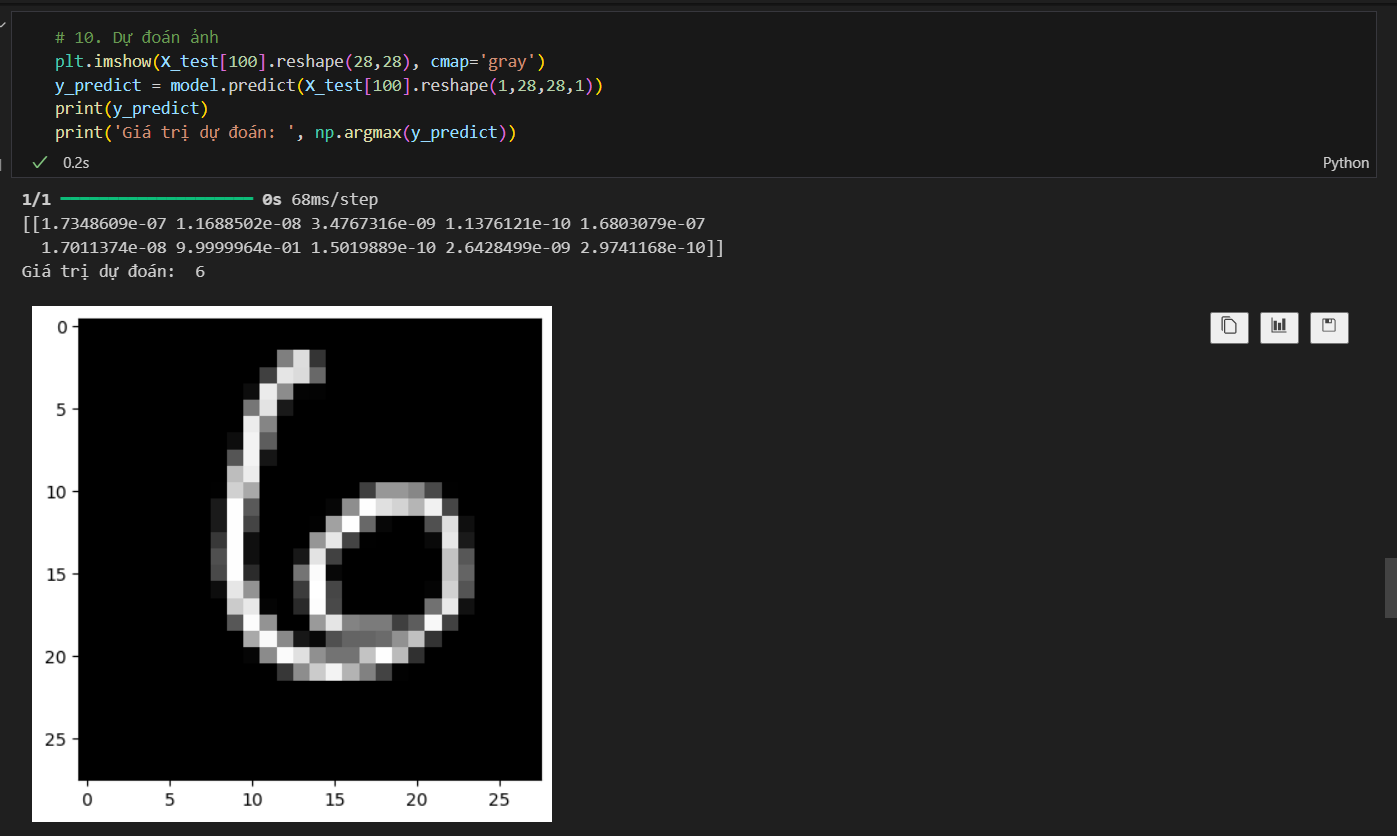
Trong ví dụ trên, bạn đã sử dụng mô hình để dự đoán một ảnh từ tập dữ liệu kiểm tra. Khi bạn gọi `model.predict(X_test[100].reshape(1,28,28,1))`, mô hình sẽ dự đoán lớp của ảnh được truyền vào. Kết quả trả về là một vector xác suất cho mỗi lớp có thể có. Trong trường hợp này, vector đó có 10 phần tử, mỗi phần tử thể hiện xác suất của mỗi lớp từ 0 đến 9.

Sau đó, bạn sử dụng `np.argmax(y_predict)` để tìm ra chỉ mục của phần tử có giá trị lớn nhất trong vector xác suất. Chỉ mục này tương ứng với lớp mà mô hình dự đoán cho ảnh đó. Trong trường hợp của bạn, chỉ mục đó là 6, nghĩa là mô hình dự đoán rằng ảnh đó chứa chữ số 6.

#### 2. Ta có danh sách vector đặc trưng và label tương ứng của các vector đặc trưng , giờ chia nó ra thành dữ liệu để huấn luyện 

In [15]:
# Chia traing set, test set tỉ lệ 80-20
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

Dòng code này thực hiện tìm kiếm lưới (grid search) để tìm ra các siêu tham số tốt nhất cho mô hình. Cụ thể:

- `params` là một từ điển chứa các giá trị của các siêu tham số cần tinh chỉnh. Trong trường hợp này, chúng ta tinh chỉnh siêu tham số `C`, là hệ số trong regularization.
- `GridSearchCV` là một công cụ từ thư viện scikit-learn giúp tìm ra các siêu tham số tối ưu bằng cách thử tất cả các tổ hợp có thể từ các giá trị đã chỉ định.
- `LogisticRegression()` tạo ra một mô hình hồi quy logistic mà chúng ta muốn tinh chỉnh.
- `model.fit(X_train, y_train)` thực hiện việc huấn luyện mô hình trên tập dữ liệu huấn luyện để tìm ra các giá trị siêu tham số tốt nhất.
- `model.best_params_` trả về các giá trị tối ưu nhất cho các siêu tham số được tìm thấy.

Kết quả là `model.best_params_` sẽ chứa các giá trị tối ưu nhất cho siêu tham số `C`.

#### Xây dựng Model và Fit Model 
- Đầu vào X_train là các vector đặc trưng
- Đầu ra y_train là các nhãn dự đoán 
- Sau khi có được các đặc trưng khi cho ảnh qua pre_train model VGG16 thì ta tạo ra Model riêng của mình và huấn luyện nó : 
model = GridSearchCV(LogisticRegression(), params) 


In [16]:
# Grid search để tìm các parameter tốt nhất cho model. C = 1/lamda, hệ số trong regularisation. Solver là kiểu optimize
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = {'C' : [0.1, 1.0, 10.0, 100.0]}
#model = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='multinomial'), params)
model = GridSearchCV(LogisticRegression(), params) 
model.fit(X_train, y_train) # HUẤN LUYỆN MODEL 
print('Best parameter for the model {}'.format(model.best_params_)) 
print("Best parameters for the model:", model.best_params_)
print("Best estimator:", model.best_estimator_)

Best parameter for the model {'C': 0.1}
Best parameters for the model: {'C': 0.1}
Best estimator: LogisticRegression(C=0.1)


In [17]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ 
# print(preds) # nhãn dưới dạng số 
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.92      0.92      0.92        13
           2       0.94      0.94      0.94        18
           3       0.74      0.89      0.81        19
           4       0.94      0.84      0.89        19
           5       0.72      0.93      0.81        14
           6       0.73      0.85      0.79        13
           7       0.92      0.85      0.88        13
           8       1.00      1.00      1.00        11
           9       0.94      0.89      0.92        19
          10       1.00      0.83      0.91        18
          11       1.00      0.86      0.92        14
          12       0.90      0.90      0.90        21
          13       1.00      0.82      0.90        22
          14       0.95      0.95      0.95        19
          15       0.71      0.71      0.71        14
          16       1.00      0.83      0.91         6

    accuracy              

In [18]:
# Lấy ra mô hình tốt nhất từ GridSearchCV
best_model = model.best_estimator_

# Đánh giá mô hình tốt nhất trên tập kiểm tra
score = best_model.score(X_test, y_test)
print("Accuracy on test set:", score)

Accuracy on test set: 0.8860294117647058


Save model finaly

In [27]:
import joblib
joblib.dump(best_model, './models/best_logistic_regression_model.pkl')

['./models/best_logistic_regression_model.pkl']

In [64]:
loaded_best_model = joblib.load('./models/best_logistic_regression_model.pkl')

image_path = list(paths.list_images('dataset/'))
random.shuffle(image_path)

imagePath = random.choice(image_path)
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, 0)

VGG16_base_model = load_model('./models/VGG16_base_model.h5')
feature = VGG16_base_model.predict(image) # Vector đặc trưng 
feature = feature.reshape((feature.shape[0], 512*7*7))

pred = loaded_best_model.predict(feature) 

print(imagePath)
print(label_names[pred[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
dataset/Crocus\image_0365.jpg
Crocus


Mã bạn đã cung cấp là một phần của quá trình đánh giá hiệu suất của mô hình phân loại trên tập dữ liệu thử nghiệm (X_test). Dòng code đầu tiên, `preds = model.predict(X_test)`, dùng để dự đoán nhãn cho các mẫu trong tập dữ liệu thử nghiệm.

Tiếp theo, `print(classification_report(y_test, preds))` hiển thị báo cáo đánh giá hiệu suất của mô hình. Trong báo cáo này:

- Precision (độ chính xác) là tỷ lệ giữa số lượng mẫu được dự đoán chính xác trong một lớp so với tổng số mẫu được dự đoán là thuộc lớp đó.
- Recall (độ phủ) là tỷ lệ giữa số lượng mẫu được dự đoán chính xác trong một lớp so với tổng số mẫu thực sự thuộc lớp đó.
- F1-score là trung bình điều hòa của precision và recall. Nó cung cấp một phép đo tổng thể về hiệu suất của mô hình.
- Support là số lượng mẫu thực sự thuộc vào mỗi lớp trong tập dữ liệu thử nghiệm.

Bằng cách đánh giá các chỉ số này, bạn có thể đánh giá hiệu suất của mô hình phân loại trên tập dữ liệu thử nghiệm. Trong trường hợp này, bạn đã có một báo cáo đánh giá chi tiết về độ chính xác, độ phủ, và f1-score cho từng lớp cũng như trung bình trên toàn bộ tập dữ liệu thử nghiệm. Điều này giúp bạn hiểu được mô hình của mình hoạt động tốt như thế nào trên các lớp khác nhau trong tập dữ liệu.

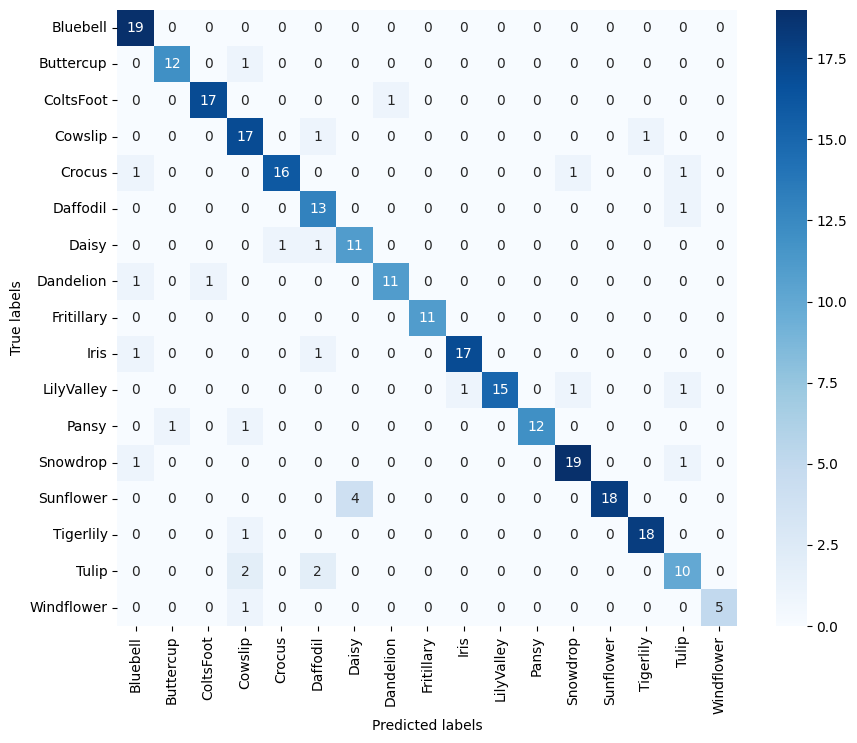

In [19]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, preds)

# Chuyển nhãn số thành tên loài hoa
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]

# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


#### 3. Feature Extractor New Flower and Recognition

Khi bạn đã có một mô hình được huấn luyện cho nhận diện khuôn mặt và muốn thêm khuôn mặt mới vào, có một số hướng giải quyết phổ biến:

1. **Tái huấn luyện mô hình:**
   - Thu thập dữ liệu mới cho khuôn mặt mới và kết hợp với dữ liệu đã có.
   - Sử dụng dữ liệu mới này để tái huấn luyện mô hình nhận diện khuôn mặt.
   - Điều này đảm bảo rằng mô hình có thể nhận diện được khuôn mặt mới.

2. **Transfer Learning:**
   - Sử dụng phương pháp transfer learning để cập nhật một phần của mô hình đã được huấn luyện với dữ liệu mới.
   - Bạn có thể giữ lại các lớp phía trước của mô hình (ví dụ: các lớp Convolutional), và chỉ cập nhật các lớp cuối cùng hoặc thêm các lớp mới để phù hợp với dữ liệu mới.
   - Điều này giúp tiết kiệm thời gian và tài nguyên huấn luyện so với việc huấn luyện lại toàn bộ mô hình.

3. **Fine-tuning:**
   - Tinh chỉnh (fine-tuning) một mô hình đã được huấn luyện sẵn để thích ứng với dữ liệu mới.
   - Bắt đầu bằng cách sử dụng một mô hình đã được huấn luyện cho nhiệm vụ nhận diện khuôn mặt (ví dụ: mô hình có sẵn trên thị trường hoặc một mô hình mà bạn đã huấn luyện trước đó).
   - Tiếp tục huấn luyện mô hình này với dữ liệu mới để cập nhật trọng số và cải thiện hiệu suất nhận diện khuôn mặt.

4. **Thêm dữ liệu vào tập kiểm tra:**
   - Nếu số lượng khuôn mặt mới không quá lớn và không cần phải tái huấn luyện hoặc tinh chỉnh mô hình, bạn có thể đơn giản là thêm dữ liệu mới vào tập kiểm tra.
   - Điều này giúp mô hình học được các đặc trưng của khuôn mặt mới mà không cần phải thay đổi cấu trúc hoặc trọng số của mô hình.

5. **Sử dụng kỹ thuật Ensemble:**
   - Kết hợp (ensemble) mô hình đã được huấn luyện sẵn với một số mô hình mới được huấn luyện trên dữ liệu mới.
   - Kỹ thuật ensemble giúp cải thiện độ chính xác và độ tin cậy của hệ thống nhận diện khuôn mặt.

Mỗi hướng giải quyết có ưu nhược điểm riêng, và sự lựa chọn phụ thuộc vào ngữ cảnh cụ thể của vấn đề và tài nguyên có sẵn.

#### Một nhãn nhưng có nhiều ảnh , nhiều đặc trưng . Gộp các đặc trưng đó lại để tăng độ chính xác 

Để biểu diễn 10 đặc trưng của 10 ảnh thành một đặc trưng duy nhất, bạn có thể sử dụng một trong những phương pháp sau:

1. **Trung bình hóa (Mean pooling)**: Bạn có thể tính trung bình của các đặc trưng của 10 ảnh. Điều này có thể được thực hiện bằng cách tính trung bình của từng chiều của các vector đặc trưng.

2. **Tích vô hướng (Vector concatenation)**: Bạn có thể ghép nối các vector đặc trưng của 10 ảnh thành một vector đặc trưng lớn hơn. Điều này tạo ra một vector đặc trưng dài hơn, kết hợp thông tin từ tất cả các ảnh.

3. **Max pooling**: Thay vì lấy trung bình, bạn có thể chọn giá trị lớn nhất từ mỗi chiều của các vector đặc trưng của 10 ảnh. Điều này giúp giữ lại các thông tin quan trọng nhất từ mỗi vector.

4. **PCA (Principal Component Analysis)**: Bạn có thể sử dụng PCA để giảm chiều dữ liệu từ các vector đặc trưng của 10 ảnh xuống thành một vector đặc trưng duy nhất có kích thước mong muốn.

5. **LSTM (Long Short-Term Memory)**: Đối với dữ liệu tuần tự như các vector đặc trưng của các ảnh, bạn có thể sử dụng mạng LSTM để học mối quan hệ giữa chúng và tạo ra một vector đặc trưng duy nhất.

Tùy thuộc vào loại dữ liệu và mô hình mà bạn sử dụng, một phương pháp có thể hoạt động tốt hơn so với các phương pháp khác. Đôi khi, thử nghiệm và so sánh hiệu suất của các phương pháp khác nhau trên tập dữ liệu thử nghiệm có thể giúp bạn chọn ra phương pháp tốt nhất cho bài toán của mình.

##### Lưu đặc trưng của hoa mới vào database (để sau này đem ra so khớp)

In [116]:
from sklearn.metrics.pairwise import cosine_similarity

# Trích xuất vector đặc trưng của ảnh mới
def extract_feature(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(image_path, target_size=(224, 224))
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)
    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, axis=0)
    # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    image = imagenet_utils.preprocess_input(image)
    # Trích xuất vector đặc trưng
    feature = model_VGG16.predict(image)
    # Reshape vector đặc trưng
    # features = features.reshape((features.shape[0], 512*7*7)) # 512*7*7 = 25088   
    feature = feature.reshape((feature.shape[0], -1)) # tự động thành 25088 
    return feature

In [ ]:
# Đường dẫn ảnh mới cần nhận diện
new_image_path = 'path/to/your/new/image.jpg'

# Trích xuất vector đặc trưng của ảnh mới
new_feature = extract_feature(new_image_path)

# Tính toán độ tương đồng cosine giữa vector đặc trưng của ảnh mới và cơ sở dữ liệu
similarities = cosine_similarity(new_feature, features)

# Tìm loài hoa có độ tương đồng cao nhất
max_similarity_index = np.argmax(similarities)
predicted_label = labels[max_similarity_index]

# In ra nhãn tương ứng với ảnh mới
print("Predicted label:", predicted_label)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Số lượng vector đặc trưng của mỗi ảnh
# print(features.shape) # (1360,25088)
# print(features[0].shape) # (25088,) 
num_features_per_image = 25088 # Số lượng vector đặc trưng của mỗi ảnh

# Dữ liệu đầu vào cho LSTM
X_train_lstm = np.array([extract_feature(image_path) for image_path in list_of_image_paths])
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], num_features_per_image, -1))

# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(num_features_per_image, X_train_lstm.shape[2])))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(len(label_names), activation='softmax')) # len(label_names) là số lượng nhãn

# Compile mô hình
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình LSTM
model_lstm.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Trích xuất vector đặc trưng của ảnh mới
new_feature_lstm = model_lstm.predict(new_feature.reshape((1, num_features_per_image, -1)))

# Sử dụng vector đặc trưng của ảnh mới để dự đoán nhãn
predicted_label_lstm = np.argmax(new_feature_lstm)

# Chuyển nhãn số thành tên loài hoa
predicted_flower_name_lstm = le.inverse_transform([predicted_label_lstm])[0]
print("Predicted flower:", predicted_flower_name_lstm)


Để sử dụng mạng LSTM để học mối quan hệ giữa các vector đặc trưng của ảnh và tạo ra một vector đặc trưng duy nhất, bạn cần thực hiện các bước sau:

1. **Chuẩn bị dữ liệu đầu vào cho LSTM**: Dữ liệu đầu vào cho LSTM cần có định dạng (số lượng mẫu, số lượng time steps, số chiều đặc trưng). Trong trường hợp này, số lượng mẫu là n (số ảnh), số lượng time steps là số lượng vector đặc trưng của mỗi ảnh, và số chiều đặc trưng là chiều của mỗi vector đặc trưng.

2. **Xây dựng mô hình LSTM**: Bạn cần xây dựng một mô hình LSTM sử dụng framework như Keras. Mô hình này sẽ học mối quan hệ giữa các vector đặc trưng và tạo ra một vector đặc trưng duy nhất.

3. **Huấn luyện mô hình LSTM**: Huấn luyện mô hình LSTM trên dữ liệu đầu vào.

4. **Sử dụng mô hình đã huấn luyện để tạo ra vector đặc trưng cho ảnh mới**: Sử dụng mô hình đã huấn luyện để dự đoán vector đặc trưng cho ảnh mới.

Lưu ý rằng bạn cần điều chỉnh các thông số như số lượng units của LSTM, số lượng epochs, batch size và các tham số khác của mạng LSTM để phù hợp với bài toán của bạn.